In [2]:
import datascrape as ds
from datetime import date
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## The idea
A <a href="http://journals.ametsoc.org/doi/abs/10.1175/1520-0450(1982)021%3C1024:FMTDRD%3E2.0.CO%3B2">well-cited paper</a> discusses modelling the volume of precipitation based on historical precipitation data. Using a statistical approach, we can come up with a probablistic model based on the Gamma distribution, which has empirically been a good model for this problem.

The paper was written in the early 80s so some of the suggestions in the paper were not actually implemented due to the difficulty of performing the calculations analytically. Based on some of those suggestions, we use the benefit of pyMC to actually implement some similar ideas and then apply it to some of the recent data we have gathered.

## The Data
Using the data we have already scraped, we can get the 2015 data for New Bedford into a dataframe. We picked New Bedford because it tends to get a fair amount of rain and a fairly large number of rainy days.

In [3]:
# Get all the data for a single year
year = 2015
city = 'KEWB' # New Bedford
dd = ds.fetch_data(city, date(year, 1, 1), date(year, 12, 31))

We start by taking a look at a plot of the data. We are only interested here in the precipitation data over the course of the year.

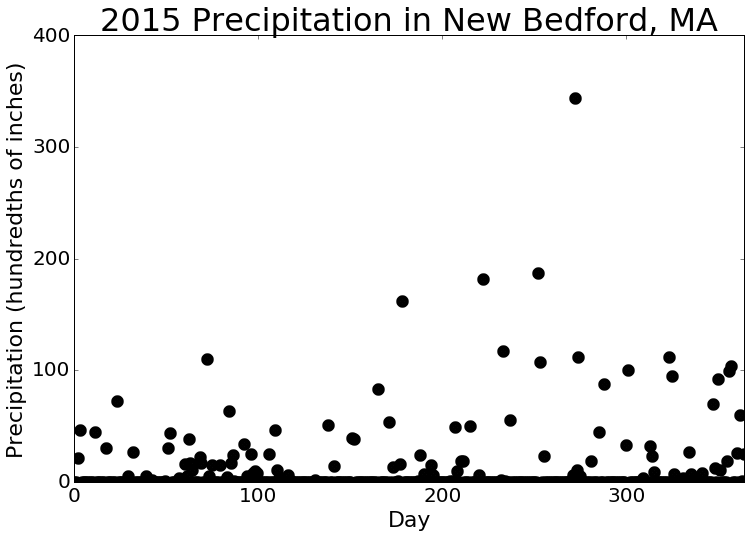

In [20]:
obs_rainfall = list(dd['PrecipitationIn'] * 100) # Convert to hundredths of inches

plt.figure(figsize=(12,8))
plt.scatter(range(len(obs_rainfall)), obs_rainfall, lw=8, c='black')
plt.xlabel('Day', fontsize=22)
plt.ylabel('Precipitation (hundredths of inches)', fontsize=22)
plt.title('2015 Precipitation in New Bedford, MA', fontsize=32)
plt.tick_params(labelsize=20)
plt.xticks(np.arange(0, 351, 100))
plt.yticks(np.arange(0, 401, 100))
plt.xlim( (0, 364) )
plt.ylim( (0, 400) )
plt.savefig('prec_nbed_2015.png', dpi=150)
plt.show()

The plot is quite interesting because there appears to be a clear distinction in the volume of rainfall between the start of the year and the end of the year. It appears that at the start of the year, the precipitation is relatively low, but after a switching point somewhere around the middle, the precipitation is generally higher than in the first half.

This will become important later as we evolve the complexity of the model to more accurately reflect weather patterns. Logically, it would also make sense for there to be different volumes over the course of the year. The rain that occurs in Spring/Summer are probably going to be of a different character to the rain that occurs in Winter. It would probably even make sense to have a different mean for each season, and potentially even a cyclic mean that varies over the time parameter.

(array([ 33.,  13.,  13.,  11.,   5.,   3.,   6.,   4.,   1.,   1.,   2.,
          1.,   1.,   2.,   2.,   3.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   1.  ,    7.86,   14.72,   21.58,   28.44,   35.3 ,   42.16,
          49.02,   55.88,   62.74,   69.6 ,   76.46,   83.32,   90.18,
          97.04,  103.9 ,  110.76,  117.62,  124.48,  131.34,  138.2 ,
         145.06,  151.92,  158.78,  165.64,  172.5 ,  179.36,  186.22,
         193.08,  199.94,  206.8 ,  213.66,  220.52,  227.38,  234.24,
         241.1 ,  247.96,  254.82,  261.68,  268.54,  275.4 ,  282.26,
         289.12,  295.98,  302.84,  309.7 ,  316.56,  323.42,  330.28,
         337.14,  344.  ]),
 <a list of 50 Patch objects>)

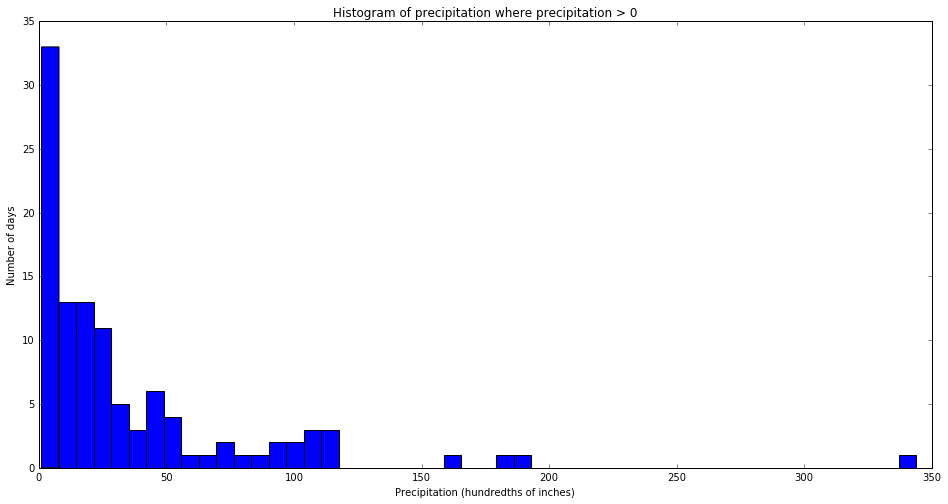

In [127]:
plt.figure(figsize=(16,8))
plt.xlabel('Precipitation (hundredths of inches)')
plt.ylabel('Number of days')
plt.title('Histogram of precipitation where precipitation > 0')
plt.hist(dd[dd['PrecipitationIn'] > 0]['PrecipitationIn'] * 100, bins=50)

As the histogram reveals, when it does rain, it tends to rain a relatively small amount each day (generally less than 0.5 inches.)

In [129]:
obs_rainfall = dd[dd['PrecipitationIn'] > 0]['PrecipitationIn'] * 100 # Get only days where precipitation > 0

## The basic model
We start with the straight-forward Gaussian model, attempting to fit the model parameters. Note that based on the paper, we have $\alpha = k$ and $\beta = \frac{\alpha}{\mu}$ so that the mean $E[x] = \mu$.

 [-----------------100%-----------------] 100000 of 100000 complete in 8.7 secPlotting alpha
Plotting mu


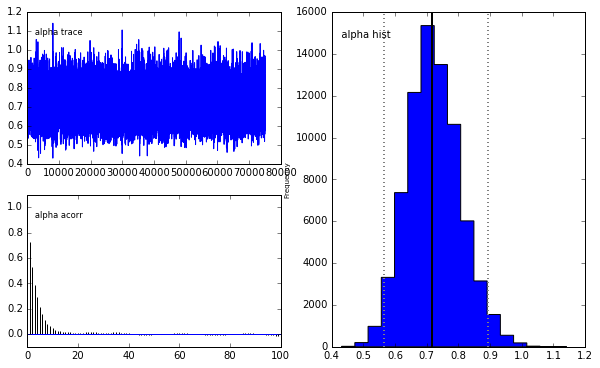

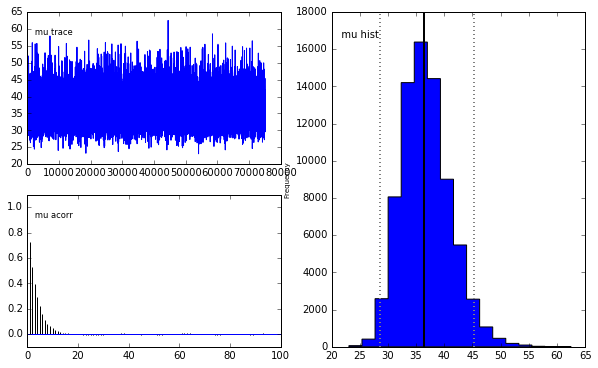

In [132]:
# Reference: from the labs
samples = 100000
p_ak = pm.Uniform("alpha", 0.0001, 10)
p_mu = pm.Uniform("mu", 0.5, 100)

#Likelihood function which incorporates our known data for the county of interest
likelihood = pm.Gamma("observation", alpha=p_ak, beta=p_ak/p_mu, value=obs_rainfall, observed=True)
#Create the Bayesian model for pymc
mcmc = pm.MCMC([p_ak, p_mu, likelihood])
#Ask pymc to run the sampler, specifying the burn in to be discarded
mcmc.sample(iter=samples, burn=samples / 4 )

#Examine the sampling procedure
#Check for autocorrelation among samples
fig = plt.figure(figsize=(32,16))
pm.Matplot.plot(mcmc, new=True)

In [133]:
print (mcmc.summary())


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.723            0.083            0.001            [ 0.564  0.892]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.57             0.666           0.718          0.777         0.899
	

mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	36.755           4.321            0.041          [ 28.666  45.198]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	29.406           33.713          36.411         39.342        46.182
	
None


/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


The trace, the autocorrelation, and the histogram plots look good so it appears we have converged to a reasonable set of values for the model parameters. In this case:
 - $\alpha$ has mean 0.723 and standard deviation 0.083
 - $\mu$ has mean 36.755 and standard deviation 4.321

The variance for $\mu$ has a very large standard deviation, suggesting this simple model is not quite capturing the changes occurring in the data. As discussed at the start, this makes sense since over the course of a year and over different seasons, we would expect the expected amount of rain per rainy day to differ depending on which time of the year it is.

## Creating a switch point
We can imagine that as the seasons change, there will be different levels of rainfall. Probably heavier rainfall would occur during winter than spring, for example. Therefore, rather than simply having a $\mu$ that is represented by a single value, we can model $\mu$ as being a hybrid function that takes on one value for one part of the year, and then a second value for another part of the year. We could also extend this to 4 different steps since there are four seasons, but judging by the plot of the data, it seems 2 different steps should be sufficient.

At this point, we keep the $\alpha$ constant. According to Coe et al., this has some empirical support, but we will relax this assumption later and see if it has any effect.

 [-----------------100%-----------------] 100000 of 100000 complete in 24.8 secPlotting switch_a
Plotting a0
Plotting a1
Plotting alpha


/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


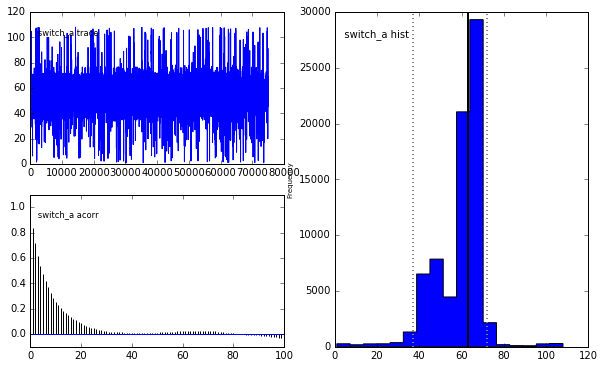

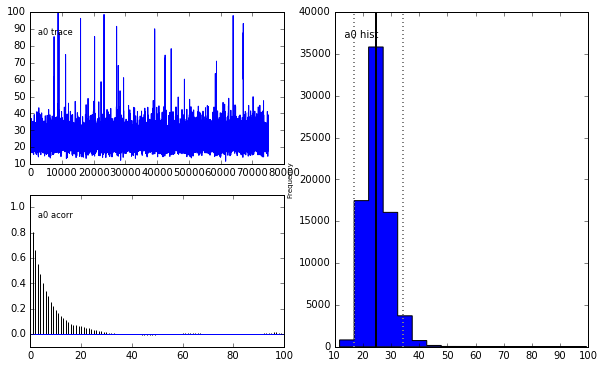

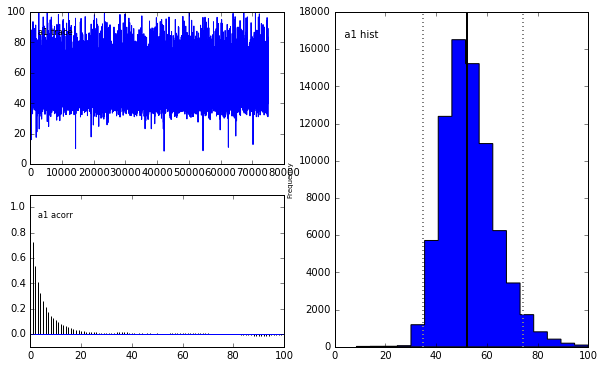

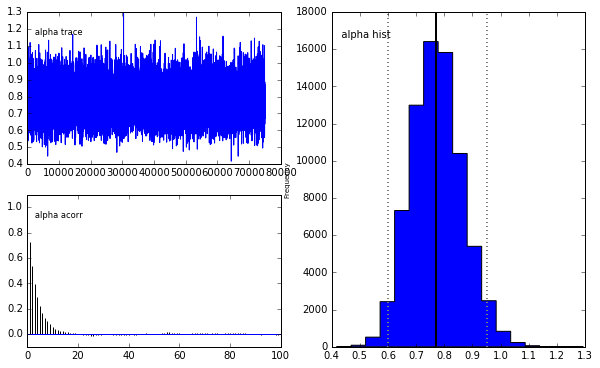

In [148]:
# Reference: from the labs
#The prior for the rate parameter
samples = 100000
p_ak = pm.Uniform("alpha", 0.0001, 10)
a_0 = pm.Uniform("a0", 0.01, 100)
a_1 = pm.Uniform("a1", 0.01, 100)
switch_a = pm.Uniform("switch_a", 1, len(obs_rainfall))

# Ref: https://pymc-devs.github.io/pymc/tutorial.html
@pm.deterministic(plot=False)
def p_mu(a0 = a_0, a1 = a_1, sa=switch_a):
    N = len(obs_rainfall)
    out = np.empty(N)
    out[:sa] = a0
    out[sa:] = a1
    return out

#Likelihood function which incorporates our known data for the county of interest
likelihood = pm.Gamma("observation", alpha=p_ak, beta=p_ak/p_mu, value=obs_rainfall, observed=True)
#Create the Bayesian model for pymc
mcmc = pm.MCMC([p_ak, p_mu, a_0, a_1, switch_a, likelihood])
#Ask pymc to run the sampler, specifying the burn in to be discarded
mcmc.sample(iter=samples, burn=samples / 4 )


#Examine the sampling procedure
#Check for autocorrelation among samples
plt.figure(figsize=(32,16))
pm.Matplot.plot(mcmc, new=True)
plt.savefig('foo.png', dpi=120)

In [136]:
print (mcmc.summary())


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.775            0.093            0.001            [ 0.593  0.956]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.603            0.71            0.771          0.836         0.968
	

a1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	53.127           10.312           0.12           [ 34.411  73.684]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	36.445           45.84           51.935         59.17         76.737
	

a0:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------------

/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Again, the trace, the autocorrelation, and the histogram plots look good so it appears we have converged to a reasonable set of values for the model parameters. Note that we now have a few additional parameters to the model:
 - $\alpha$ has mean 0.775 and standard deviation 0.093
 - The switching point has mean 59.1 and standard deviation 11.075 (note there are 108 rainy days)
 - $\mu_{0}$ has mean 25.11 and standard deviation 5.02
 - $\mu_{1}$ has mean 53.127 and standard deviation 10.312
 
The variance for both $\mu$ is still quite large but note that the 95% intervals do not overlap so we can roughly say (but without having calculated the test statistics,) that the two means are likely significantly different. The switching point also corresponds with the plot from earlier, occuring around the middle of the rainy days.

The turning point mean occurs at the 59th rainy day. We can see that the date is the 26th July 2015 which would be around the end of Summer.

In [147]:
print ('95% lower:\t', obs_rainfall.index[38])
print ('Mean:\t\t', obs_rainfall.index[59])
print ('95% upper\t', obs_rainfall.index[72])

95% lower:	 2015-4-21
Mean:		 2015-7-26
95% upper	 2015-9-11


 [-----------------100%-----------------] 100000 of 100000 complete in 36.2 secPlotting b1
Plotting a1
Plotting b0
Plotting switch_a
Plotting a0
Plotting switch_b


/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


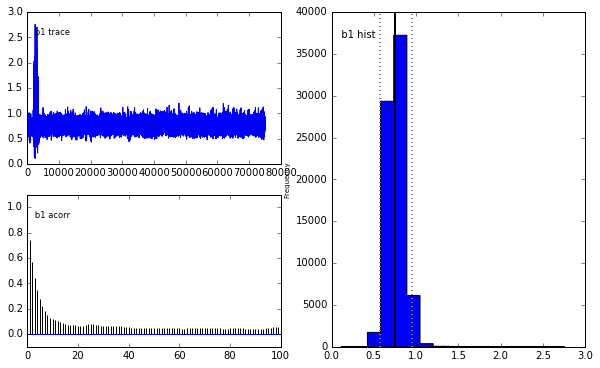

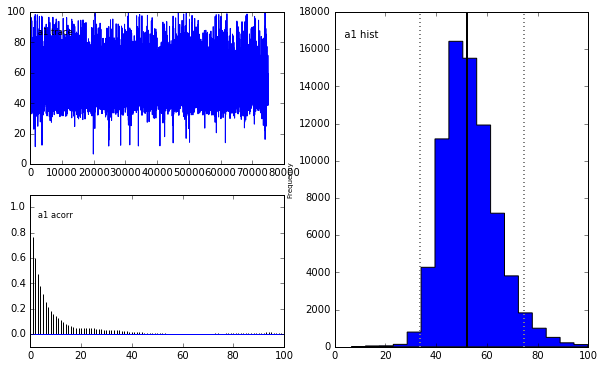

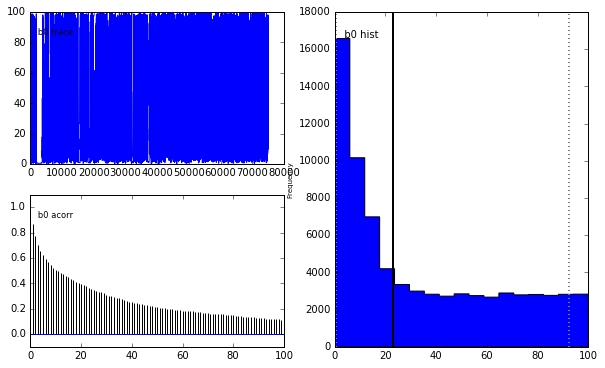

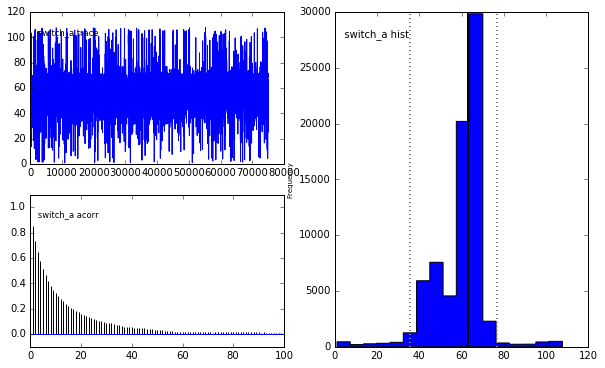

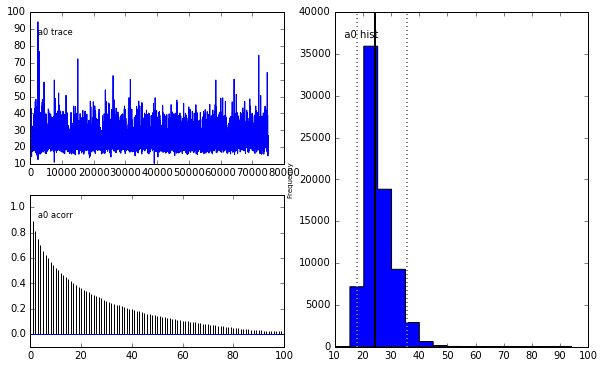

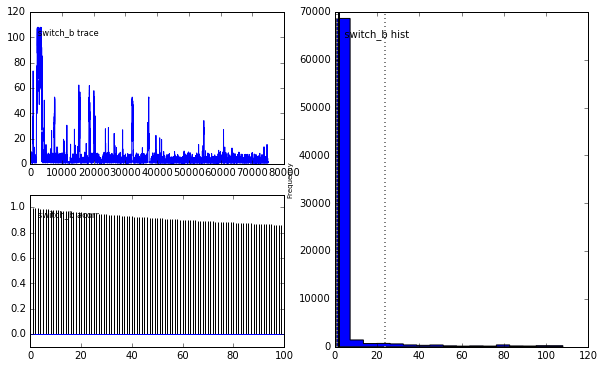

In [115]:
# Reference: from the labs
#The prior for the rate parameter
samples = 100000
p_ak = pm.Uniform("alpha", 0.0001, 10)
a_0 = pm.Uniform("a0", 0.01, 100)
a_1 = pm.Uniform("a1", 0.01, 100)
b_0 = pm.Uniform("b0", 0.01, 100)
b_1 = pm.Uniform("b1", 0.01, 100)
switch_a = pm.Uniform("switch_a", 1, len(obs_rainfall))
switch_b = pm.Uniform("switch_b", 1, len(obs_rainfall))
# p_mu = pm.Uniform("mu", 0.5, 100)

# Ref: https://pymc-devs.github.io/pymc/tutorial.html
@pm.deterministic(plot=False)
def p_mu(a0 = a_0, a1 = a_1, sa=switch_a):
    ''' Concatenate Poisson means '''
    N = len(obs_rainfall)
    out = np.empty(N)
    out[:sa] = a0
    out[sa:] = a1
#     for t in range(N):
#         out[t] = np.exp(a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4)
    return out

@pm.deterministic(plot=False)
def p_ak(b0 = b_0, b1 = b_1, sb=switch_b):
    ''' Concatenate Poisson means '''
    N = len(obs_rainfall)
    out = np.empty(N)
    out[:sb] = b0
    out[sb:] = b1
#     for t in range(N):
#         out[t] = np.exp(a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4)
    return out

#Likelihood function which incorporates our known data for the county of interest
likelihood = pm.Gamma("observation", alpha=p_ak, beta=p_ak/p_mu, value=obs_rainfall, observed=True)
#Create the Bayesian model for pymc
mcmc = pm.MCMC([p_ak, p_mu, a_0, a_1, b_0, b_1, switch_a, switch_b, likelihood])
#Ask pymc to run the sampler, specifying the burn in to be discarded
mcmc.sample(iter=samples, burn=samples / 4 )

#Test the function on a hypothetical small county with no deaths and a population of 1000

#Examine the sampling procedure
#Check for autocorrelation among samples
plt.figure(figsize=(32,16))
pm.Matplot.plot(mcmc, new=True)

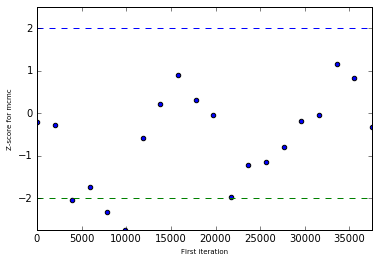

In [116]:
# Geweke plots
geweke_scores = pm.geweke(mcmc.trace("switch_a")[:], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "mcmc")

In [117]:
print(mcmc.summary())


b1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.761            0.105            0.002            [ 0.57   0.949]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.582            0.693           0.756          0.82          0.963
	

a1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	53.214           10.601           0.15           [ 33.819  74.505]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	35.969           45.897          52.055         59.34         77.789
	

p_ak:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------------

/Users/victor/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
